# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin


# Data

In [5]:
cm1 = arff.loadarff("data/cm1.arff")
jm1 = arff.loadarff("data/jm1.arff")
kc1 = arff.loadarff("data/kc1.arff")
kc2 = arff.loadarff("data/kc2.arff")
pc1 = arff.loadarff("data/pc1.arff")

In [6]:
df_cm1 = pd.DataFrame(cm1[0])
df_jm1 = pd.DataFrame(jm1[0])
df_kc1 = pd.DataFrame(kc1[0])
df_kc2 = pd.DataFrame(kc2[0])
df_pc1 = pd.DataFrame(pc1[0])

df_kc2 = df_kc2.rename(columns={
  'lOCodeAndComment': 'locCodeAndComment',
  'problems': 'defects',
})
df_pc1 = df_pc1.rename(columns={
  'iv(G)': 'iv(g)',
  'N': 'n',
  'V': 'v',
  'L': 'l',
  'D': 'd',
  'I': 'i',
  'E': 'e',
  'B': 'b',
  'T': 't',
})

df = pd.concat([df_cm1, df_jm1, df_kc1, df_kc2, df_pc1])
df = df.replace({
    b'true': True,
    b'false': False,
    b'yes': True,
    b'no': False,
})
df = df.drop_duplicates()
df = df.dropna()

# EDA

In [24]:
df.shape

(11810, 22)

In [8]:
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1.0,0.0,6.0,0.0,15.0,15.0,44.0,19.0,9.0,False
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0.0,0.0,3.0,0.0,16.0,8.0,31.0,16.0,7.0,False
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0.0,0.0,3.0,0.0,16.0,12.0,46.0,26.0,11.0,False


In [ ]:
df.dtypes

loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode               float64
lOComment            float64
lOBlank              float64
locCodeAndComment    float64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects               object
dtype: object

In [9]:
df.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,1.181000e+04,...,1.181000e+04,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000
mean,44.962075,6.830771,3.545504,4.369975,130.538975,773.362201,0.113157,15.720767,33.799660,3.947253e+04,...,2.195775e+03,29.098391,3.641406,5.688146,0.453937,12.535157,19.632870,77.708400,52.930246,12.232887
std,76.152577,13.027112,6.876961,9.194026,253.555962,1976.110948,0.140019,18.440564,35.576456,4.216946e+05,...,2.344381e+04,59.655158,10.849646,11.230608,2.127000,9.833259,27.998108,153.586046,102.207008,22.776277
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,14.000000,2.000000,1.000000,1.000000,25.000000,100.320000,0.040000,5.340000,15.152500,5.743550e+02,...,3.191250e+01,6.000000,0.000000,1.000000,0.000000,7.000000,6.000000,15.000000,10.000000,3.000000
50%,25.000000,4.000000,1.000000,2.000000,63.000000,293.890000,0.070000,11.000000,25.760000,3.320345e+03,...,1.844600e+02,15.000000,0.000000,3.000000,0.000000,12.000000,13.000000,37.000000,25.000000,7.000000
75%,50.000000,7.000000,4.000000,5.000000,139.000000,741.412500,0.140000,20.530000,41.967500,1.450225e+04,...,8.056800e+02,33.000000,3.000000,6.000000,0.000000,17.000000,24.000000,83.000000,56.000000,13.000000
max,3442.000000,470.000000,165.000000,402.000000,8441.000000,80843.080000,2.000000,418.200000,598.330000,3.107978e+07,...,1.726655e+06,2824.000000,344.000000,447.000000,108.000000,411.000000,1026.000000,5420.000000,3021.000000,826.000000


In [10]:
df.skew()

loc                  14.341604
v(g)                 14.399692
ev(g)                 8.252738
iv(g)                19.909795
n                     9.785942
v                    14.436395
l                     5.037462
d                     5.985375
i                     4.895119
e                    46.671078
b                    14.431094
t                    46.585228
lOCode               16.812267
lOComment            10.555280
lOBlank              10.838003
locCodeAndComment    18.020673
uniq_Op              14.258877
uniq_Opnd            11.940540
total_Op             10.553696
total_Opnd            8.840808
branchCount          11.005150
defects               1.393236
dtype: float64

In [16]:
df.mode().iloc[0]

loc                   11.0
v(g)                   1.0
ev(g)                  1.0
iv(g)                  1.0
n                      0.0
v                      0.0
l                      0.0
d                      0.0
i                      0.0
e                      0.0
b                      0.0
t                      0.0
lOCode                 0.0
lOComment              0.0
lOBlank                0.0
locCodeAndComment      0.0
uniq_Op                0.0
uniq_Opnd              0.0
total_Op               0.0
total_Opnd             0.0
branchCount            1.0
defects              False
Name: 0, dtype: object

In [18]:
df.mean()

loc                     44.962075
v(g)                     6.830771
ev(g)                    3.545504
iv(g)                    4.369975
n                      130.538975
v                      773.362201
l                        0.113157
d                       15.720767
i                       33.799660
e                    39472.528776
b                        0.257953
t                     2195.775449
lOCode                  29.098391
lOComment                3.641406
lOBlank                  5.688146
locCodeAndComment        0.453937
uniq_Op                 12.535157
uniq_Opnd               19.632870
total_Op                77.708400
total_Opnd              52.930246
branchCount             12.232887
defects                  0.214225
dtype: float64

In [ ]:
df = df.dropna()
df.isna().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [23]:
df["defects"] = df["defects"].replace({b"true": True, b"false": False})
df

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1.0,0.0,6.0,0.0,15.0,15.0,44.0,19.0,9.0,False
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0.0,0.0,3.0,0.0,16.0,8.0,31.0,16.0,7.0,False
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0.0,0.0,3.0,0.0,16.0,12.0,46.0,26.0,11.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,7.0,2.0,1.0,2.0,24.0,100.08,0.18,5.63,17.79,562.94,...,7.0,1.0,2.0,0.0,10.0,8.0,15.0,9.0,3.0,False
1104,6.0,4.0,4.0,1.0,26.0,96.21,0.08,13.33,7.22,1282.82,...,6.0,0.0,2.0,0.0,10.0,3.0,18.0,8.0,7.0,False
1105,10.0,5.0,5.0,1.0,43.0,182.66,0.05,21.00,8.70,3835.88,...,10.0,0.0,1.0,0.0,14.0,5.0,28.0,15.0,9.0,False
1107,18.0,8.0,5.0,5.0,111.0,613.12,0.04,22.92,26.75,14050.56,...,18.0,0.0,1.0,0.0,22.0,24.0,61.0,50.0,15.0,False


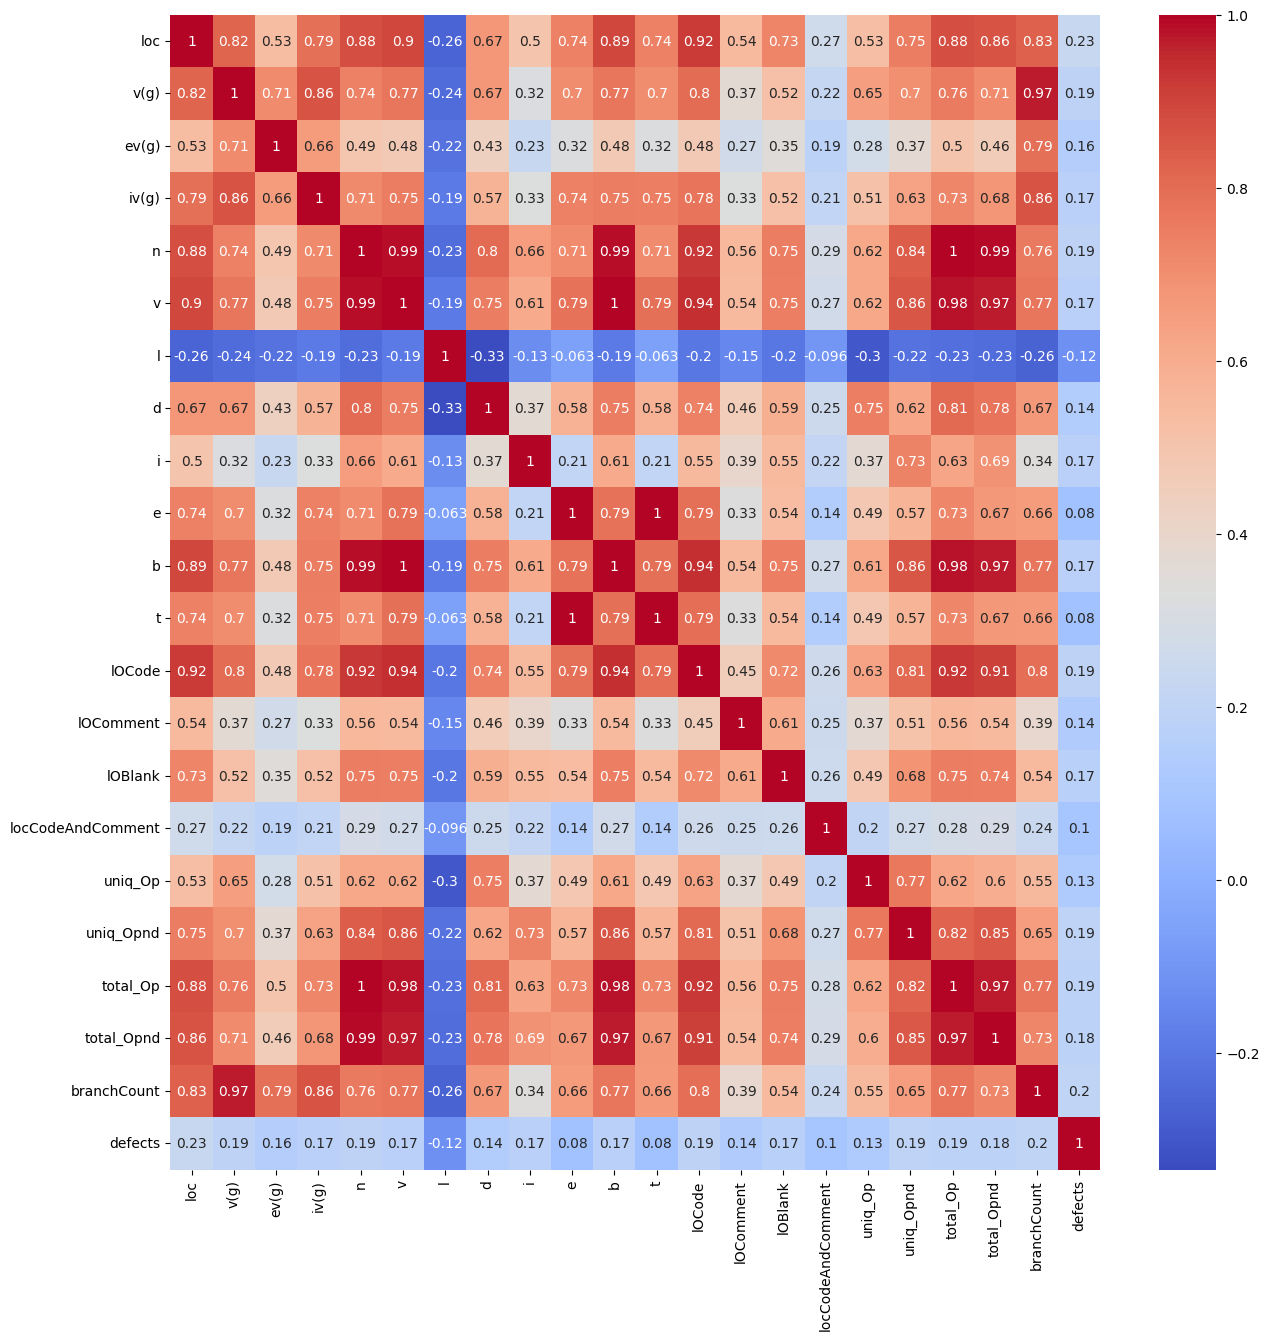

In [22]:
correlation_matrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

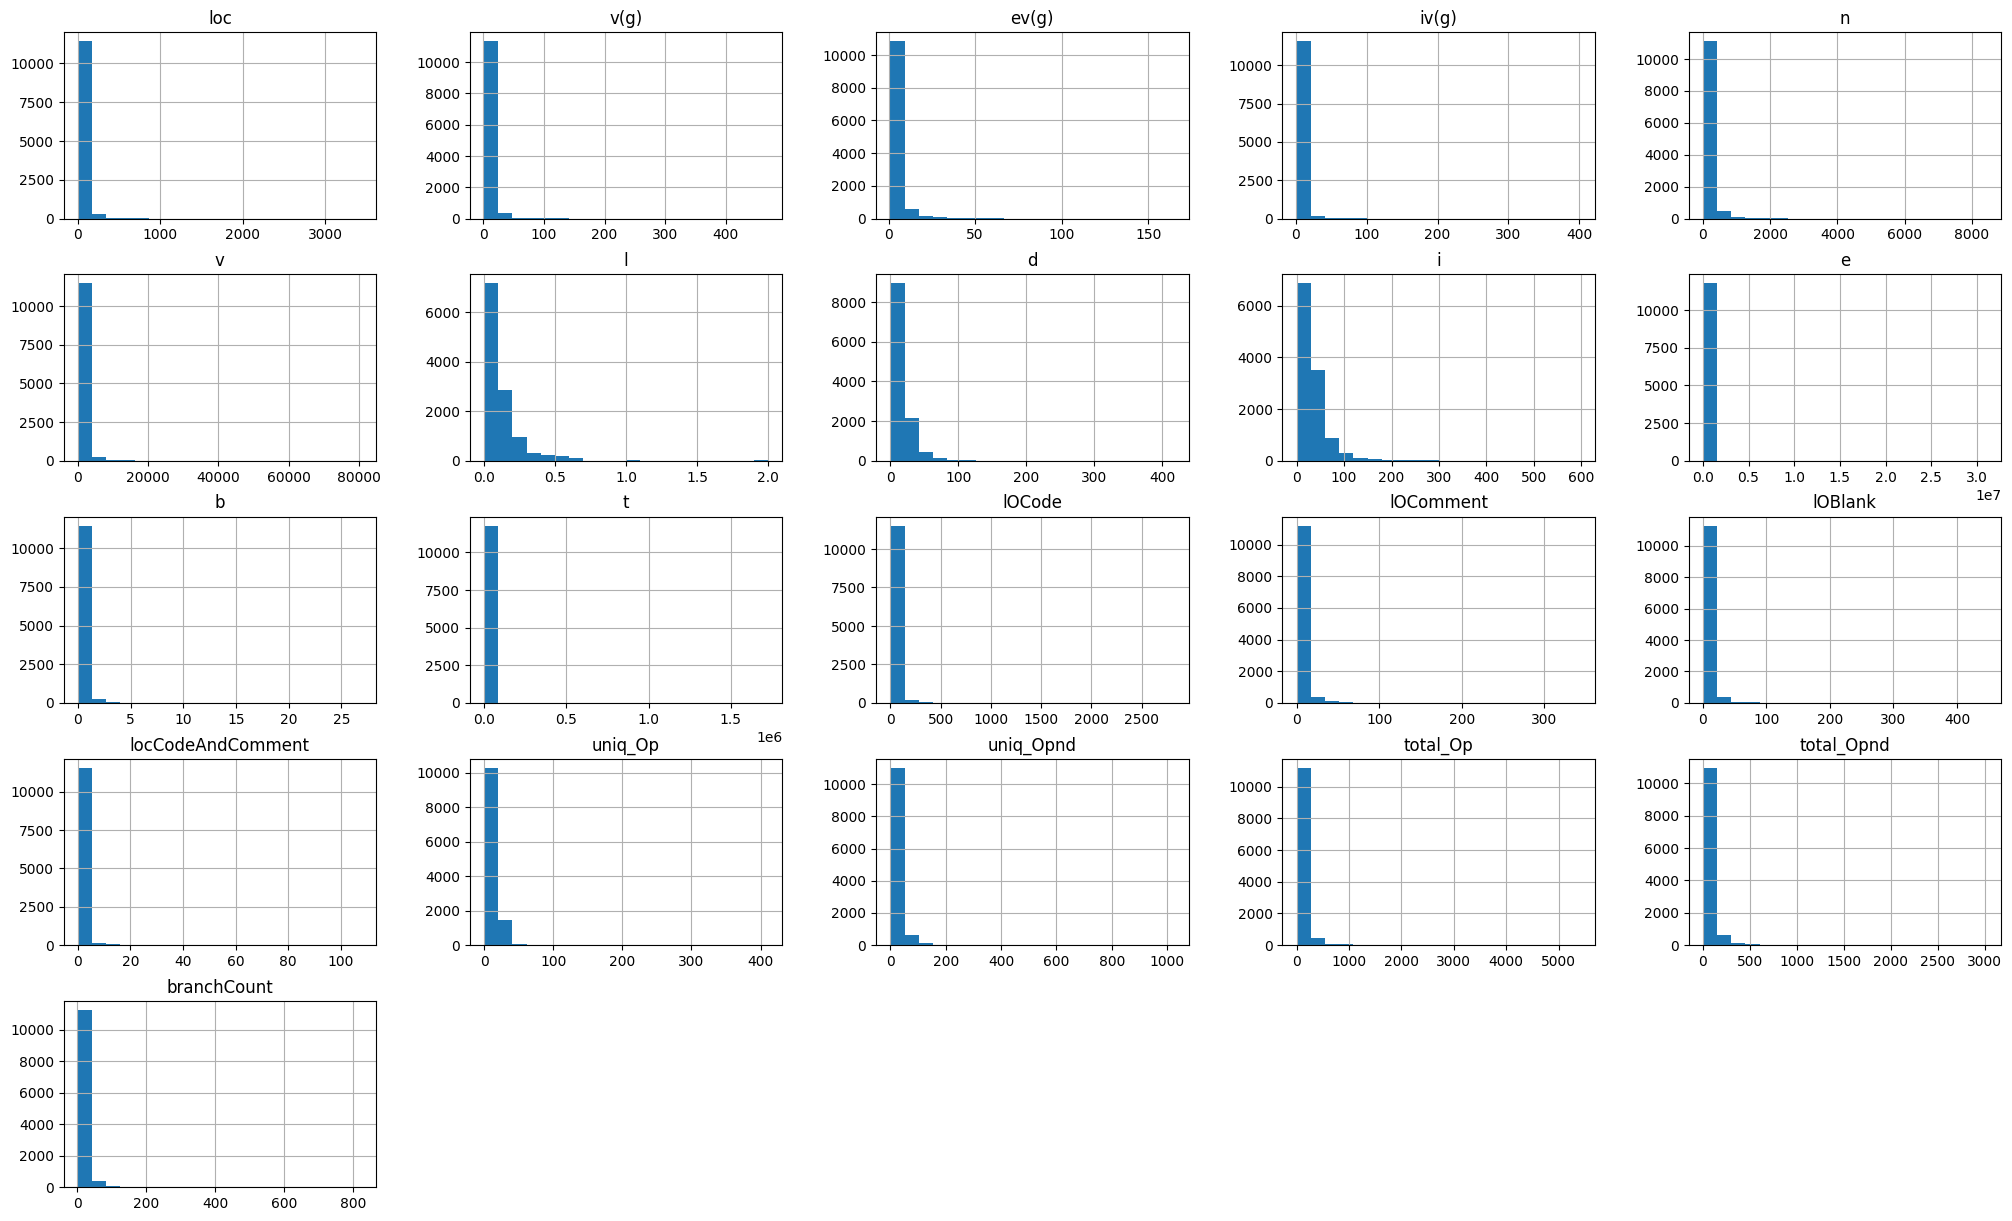

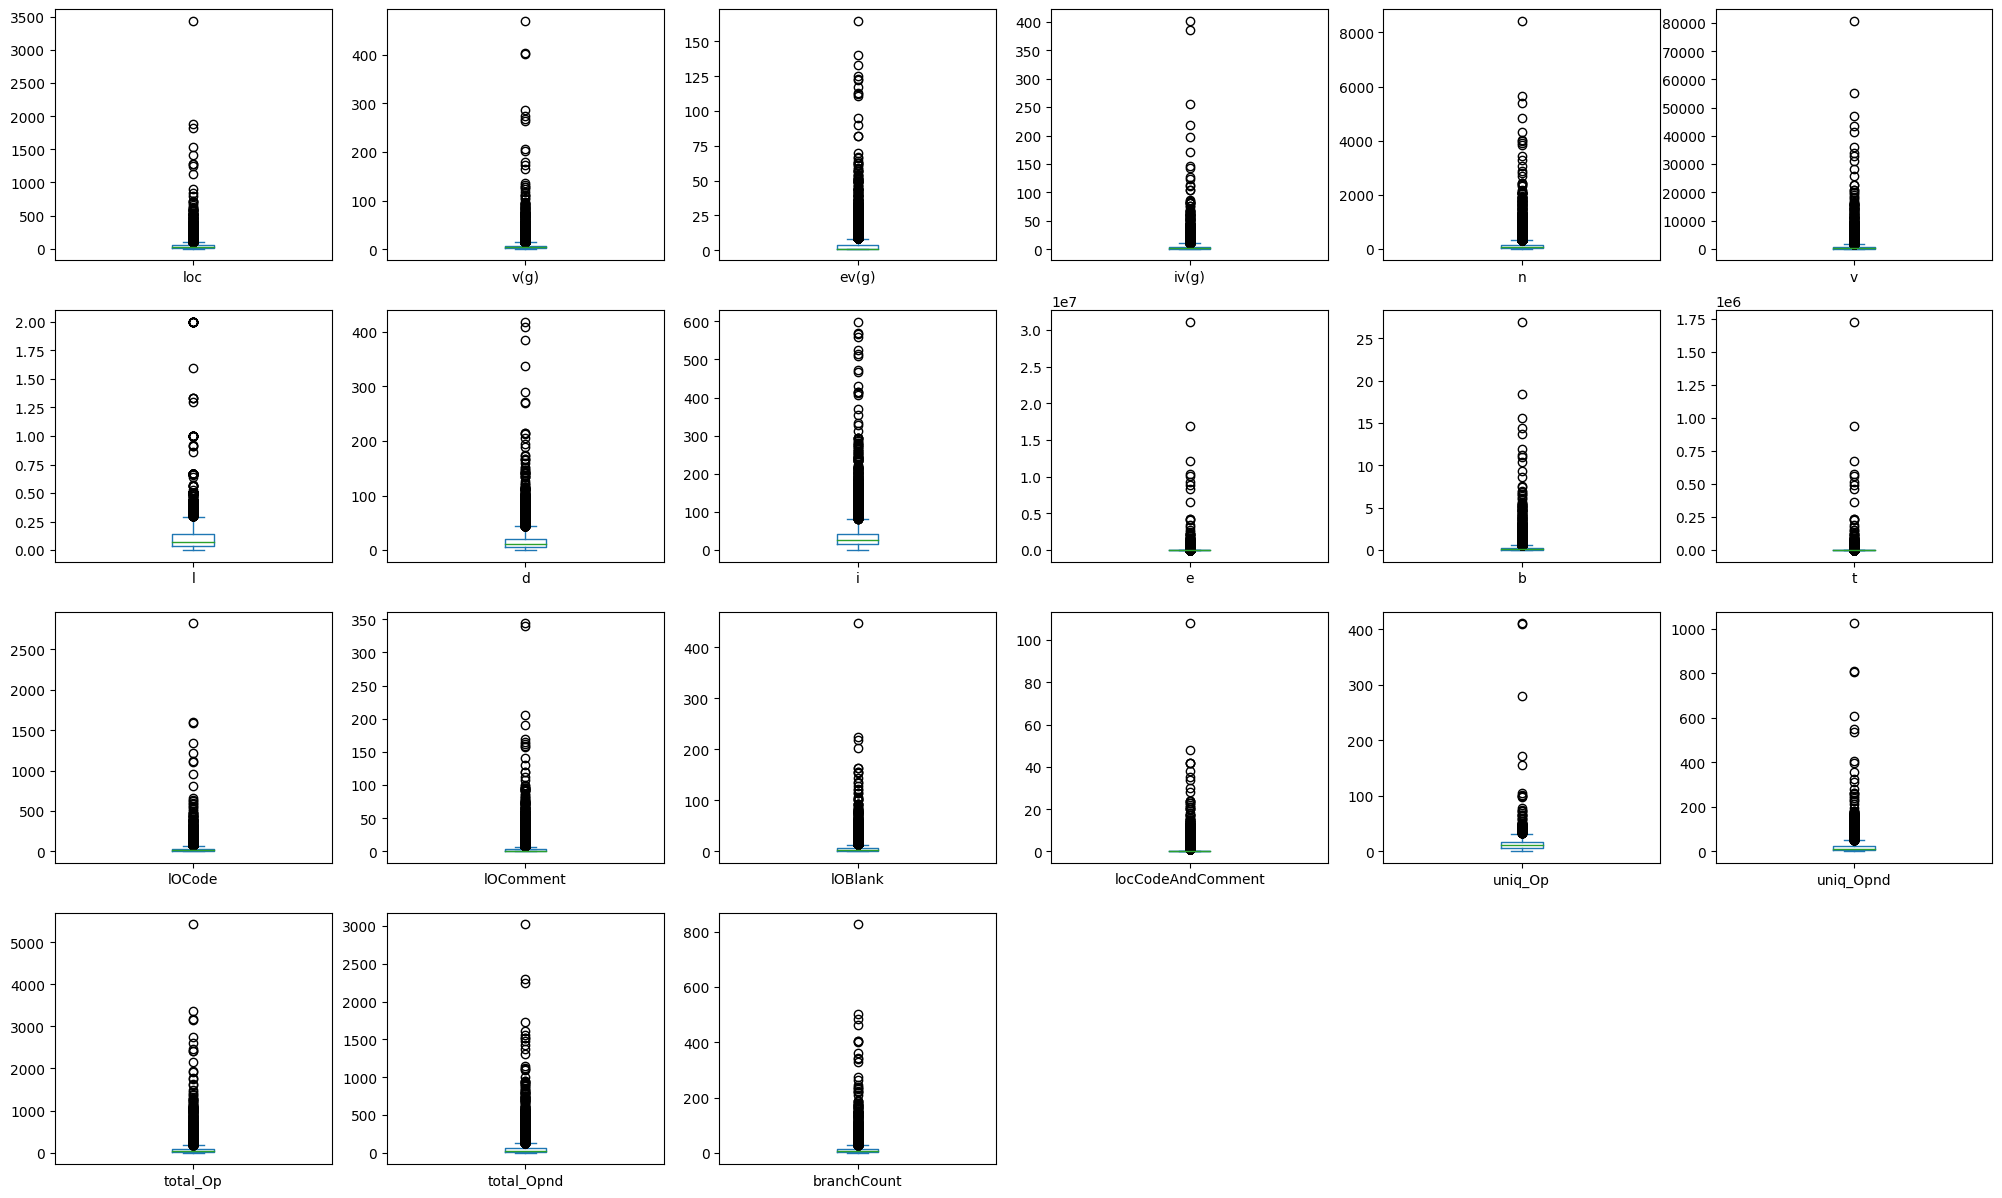

In [21]:
df.hist(bins=20, figsize=(25, 15))
plt.show()

df.plot(kind='box', subplots=True, layout=(4,6), figsize=(25, 15))
plt.show()

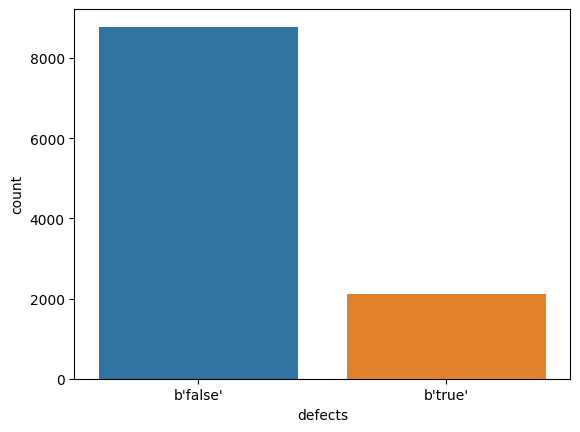

In [ ]:
sns.countplot(x='defects', data=df)
plt.show()

# Feature Engineering

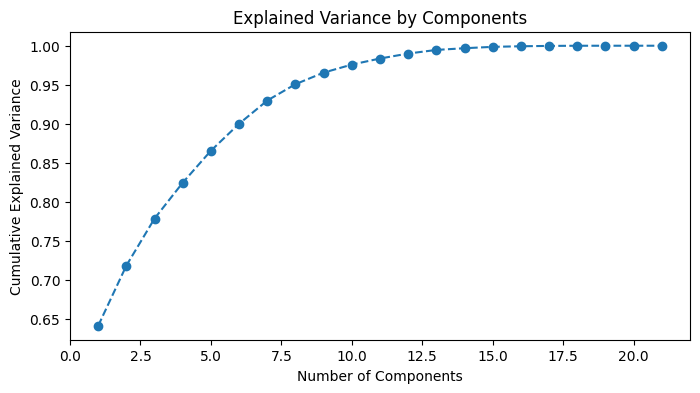

In [20]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))
pca = PCA().fit(scaled_data)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()